# Privacy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import diffprivlib.models as diff

from tqdm import tqdm

from copy import deepcopy
from itertools import combinations, product
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report

import utility as uti

import seaborn as sns
sns.set_theme(style='darkgrid')

In [3]:
%%capture
%run ./german.ipynb

In [4]:
seed = 1234
NEW = False

# Présentation des enjeux de la protection des données personnelles

---
[MOD]

Avec la part grandissante de service dépendant de méthodes d'apprentissage statistique il devient indispensable de se poser la question de la protection des données utilisé celles-ci. La protection des données dans la sphère de l'apprentissage statistique correspond à des méthodes pour se prémunir contre une utilisation adverse des outils d'apprentissage dans le but de soutirer des informations soit personnels soit confidentiels. Le but est de s'assurer qu'un modèle ne divulgue pas plus d'information que celles pour lesquelles il a été conçu.

Il y a deux raisons pour lesquelles un modèle statistique est considérée comme un actif. Premièrement, il est coûteux d'en concevoir un. Le simple fait d'entraîner un modèle peut être très coûteux, par exemple lorsque Google entraîne un modèle avec 340 millions de paramètres cela lui a coûter plus de soixante mille dollars par entraînement. Il faut également prendre en compte le temps de trouver la bonne architecture, les bonnes méthodes et paramètre du modèles. De plus, l'efficacité d'un modèle statistique repose grandement sur la qualité des données qu'il reçoit en entrée. Trouver, nettoyer et annoté une base de données et encore une autre des tâches coûteuse liée à un modèle. 
Deuxièmement, il y a des enjeux de sécurité et de confidentialité liée au modèle lui même. La base de données peut contenir des informations sensibles ou encore l'utilisateur du modèle peut vouloir s'assurer de l'utilisation des informations qu'il les fournis.

Les différentes attaques de protection des données sont les suivantes :
 - Inférence d'appartenance : cette attaque cherche à déterminer si une entrée particulière à fait partie de la base d'entraînement du modèle cible. 
 - Inférence de propriété : cette attaque cherche à inférer des propriétés de la base de données d'entraînement du modèle cible. 
 - Copie de modèle : cette attaque cherche à récupérer des informations plus ou moins précise sur un modèle dit boite noire, cela signifie que les éléments constituant le modèle ne sont pas accessible à l'utilisateur. 

Et les deux méthodes principales de défense sont : 
 - Cryptologie : cette défense est plus tourné vers la confidentialité dans le sens où un des parties veut pas échanger d'information avec les autres. Par exemple, il existe des méthodes permettant de s'assurer que les information que donnent et revoient l'utilisateur ne peuvent pas être lu par la personne en charge du modèle. 
 - Confidentialité Différentiable : cette méthode est plus un critère qui englobe différents outils permettant d'obtenir des garanties mathématique sur la protection des données contres différentes attaques.

Les différents types d'attaques peuvent avoir un impact important sur les entreprises proposant des modèles d'apprentissage statistiques. L'inférence d'appartenance et de propriétés sont des des attaques sur les bases de données impliquant soit des fuites d'information importantes soit un non respect du traitement des données personnelles. La copie de modèle, elle, peut permettre à des concurrents de réduire leur écart technologique sans avoir à supporter les coûts associés. Il est donc important de comprendre ces attaques et leurs limites mais également de connaître les différentes méthodes pour se prémunir contre celles-ci.

Dans l'étude de cas nous implémentons deux attaques et une défense. La première attaque est une copie de modèle et la deuxième est un inférence de propriété, retrouver la proportion de femme dans la base d'entraînement d'un modèle. Pour se prémunir de la copie de modèle il faut mettre en place des mesures non technique qui ne sont pas présenté ici, pour l'inférence on implémente une méthode de confidentialité différentiable.

---

# Étude de cas et implémentation

## Model extraction

Prenons le cas de figure suivant: un nouvel acteur bancaire veut se lancer dans les prêts mais plutôt que de payer une équipe pour labelliser les demandes il souhaite utiliser un modèle de la banque allemande.

Le but de cette attaque est de récupérer les paramètres du modèle afin d’en avoir une copie.
On suppose les deux choses suivantes pour que l'attaque soit possible:
 - on connaît l'architecture du modèle : régression logistique.
 - on peut utiliser le modèle cible sans contraintes (mais comme une boîte noire)

Afin de récupérer les paramètres du modèle cible, on commence par créer un modèle ayant la même architecture que le modèle cible. On va ensuite constituer une base de données à l’aide du modèle cible. Pour cela, on génère aléatoirement des entrées selon deux méthodes que l'on comparera ensuite et on labellise ces données en utilisant les sorties retournées par le modèle cible sur ces entrées.

Le nouveau modèle est ensuite entraîné avec la nouvelle base de données ainsi constituée.
Dans ce qui suit, le modèle `logreg` correspond au modèle secret qui a été entraîné sur la base de données de départ. C'est ce modèle que nous tentons de copier.

In [5]:
model_pirate = deepcopy(model)
model_secret = deepcopy(logreg)

Pour commencer, supposons que l'attaquant ait accès à une base de données d’entrées tirées selon la même distribution que les entrées utilisées pour entraîner le modèle secret. Puisque l’on a accès en boîte noire au modèle secret, on peut obtenir les sorties prédites par le modèle secret sur ces entrées et constituer notre propre base de données d’entraînement. On peut alors entraîner notre modèle sur cette base d'entraînement et regarder si notre modèle ressemble au modèle secret.

In [6]:
def new_entries(n):
    '''Retrun n new entries based on possible values and frequency of X dataset'''
    list_entries = []
    for col in X.columns:
        frequence = (X[col].value_counts(normalize=True)).to_numpy()
        entries = np.random.choice(X[col].unique(), n, p=frequence)
        list_entries.append(entries)
        
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

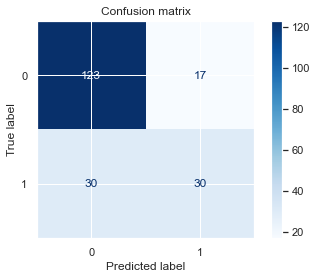

       Sensitivity  Specificity   Precision     Accuracy  
pirate     0.88         0.50         0.64         0.77    
secret     0.86         0.50         0.61         0.76    


In [7]:
n = len(X_train)
X_train_pirate = new_entries(n)
y_train_pirate = model_secret.predict(X_train_pirate)

np.random.seed(seed)
model_pirate.fit(X_train_pirate, y_train_pirate)
uti.mesure_clas_list([model_pirate, model_secret], X_test, y_test, ['pirate', 'secret'])

On remarque que le modèle extrait a des performances sur l’ensemble de test qui sont proches des performances du modèle cible. Toutefois, on remarque qu’il a tendance à l'augmenter le nombre de personnes prédites comme capable de rembourser alors qu'elles ne le sont pas.

Nous retirons maintenant l'hypothèse d’avoir accès à une base de données similaire à celle utilisée pour l’entraînement du modèle secret. On va créer notre base d’entraînement en tirant aléatoirement les variables des entrées et en utilisant le modèle secret en boîte noire pour prédire la sortie associée à chaque entrée créée.


In [8]:
def new_entries_unif(n):
    '''Retrun n new entries based on possible values uniformaly'''
    list_entries = []
    for col in X.columns:
        entries = np.random.choice(X[col].unique(), n)
        list_entries.append(entries)
        
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

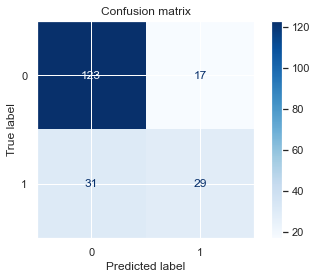

       Sensitivity  Specificity   Precision     Accuracy  
pirate     0.88         0.48         0.63         0.76    
secret     0.86         0.50         0.61         0.76    


In [9]:
n = len(X_train)

X_train_pirate_unif = new_entries_unif(n)
y_train_pirate_unif = model_secret.predict(X_train_pirate_unif)

np.random.seed(seed)
model_pirate.fit(X_train_pirate_unif, y_train_pirate_unif)
uti.mesure_clas_list([model_pirate, model_secret], X_test, y_test, ['pirate', 'secret'])

Le nouveau modèle appris a des performances semblables au modèle secret une fois encore. Jusqu’ici, pour comparer deux modèles nous avons comparé les métriques de performance de ces derniers, c’est la méthode la plus classique. Une deuxième façon de quantifier la distance entre deux modèles et de regarder leurs comportements respectifs sur des entrées identiques afin de voir si les modèles se trompent sur les mêmes entrées. La première métrique (celle que nous avons utilisée) est globale tandis que la deuxième est une métrique locale.
On note `precision` la mesure locale décrite ci-dessus et on utilise la métrique de performance “accuracy” pour avoir une mesure globale.

In [10]:
y_pirate = model_pirate.predict(X_test)
y_secret = model_secret.predict(X_test)

# Pourcentage of same prediction
precision = (y_secret == y_pirate).astype(int).sum()/len(y_secret)

# Difference of accuracy betwenne secret and pirate prediction
accu_diff = accuracy_score(y_test, y_secret) - accuracy_score(y_test, y_pirate)

print(f"local : {precision:.3f}, global : {accu_diff:.3f}")

local : 0.945, global : -0.005


Les résultats obtenus montrent que l’on a créé un modèle qui est très proche globalement et localement du modèle secret. L'évasion de modèle a ainsi très bien fonctionné.

## Créer un modèle qui surapprend

Afin de réaliser une attaque d'inférence de propriété, il est nécessaire d'attaquer un modèle ayant surappris. L’objectif de l’attaque est de récupérer des informations (des propriétés) de la base de données d'entraînement du modèle cible.
Pour cela, on va exploiter le surapprentissage et tenter d’exploiter ce que le modèle a appris sur la base de données d’entraînement.
Dans un premier temps, nous créons un modèle ayant surappris sur notre base de données. Il est difficile de faire surapprendre une régression logistique qui est un modèle simple en prolongeant seulement l’entraînement. Une façon de faciliter le surapprentissage de cette dernière est de coupler les variables de la façon suivante.

On suppose qu'une entrée dans la base de données d'origine est de la forme :
$$
x_1, x_2, ..., x_n
$$
avec $x_i$ la variable de l'individu pour la *i*-ème catégorie. 

On crée avec cette entrée la nouvelle entrée suivante pour le modèle que l’on souhaite faire surapprendre :
$$
x_1, x_2, ..., x_n, (x_i x_j)_{i,j \in C}
$$
avec $C$ l'ensemble des variables catégorielles. On augmente ainsi grandement la dimension de notre modèle ce qui facilitera le surapprentissage.
Nous créons dans un premier temps la base de données augmentée à partir de notre base de donnée initiale.

In [11]:
# We need to compute evey possibility of variables to normalise coefficient order
# in the regression as a lot of possibility will not be present every time 
all_variables = cat_variables + [f'{i}_{j}' for i, j in 
                                                 combinations(cat_variables, 2)]
all_values = [X[col].unique() for col in cat_variables]
all_combinaisons = list(combinations(all_values, 2))

categorie_values = [[a + b for a,b in list(product(*x))] for x in all_combinaisons]

def add_relations(df_orig):
    '''Takes a dataframe and add the relation define above'''
    df = df_orig.copy()
    for i, j in combinations(cat_variables, 2):
        df[f'{i}_{j}'] = df[i] + df[j]
    return df

On crée ensuite le modèle prenant en entrée les entrées de la base de donnée augmentée et on l'entraîne sur cette dernière. Le modèle est nommé `model_overfit`.

In [12]:
preprocessor_comb = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories=all_values+categorie_values, 
                              drop='first', 
                              sparse=False), all_variables),
        ('ord', StandardScaler(), ord_variables)
    ])

model_overfit = Pipeline(
    steps=[
        ('relations', FunctionTransformer(add_relations)), 
        ('preprocessor', preprocessor_comb),
        ('logreg', LogisticRegression(max_iter=200))
    ]
)

Afin de vérifier si notre modèle a bien surappris, on peut regarder ses performances sur l’ensemble d’entraînement et l’ensemble de test. Un modèle qui surapprend aura d’excellentes performances sur l’ensemble d’entraînement et des performances moins bonnes sur l’ensemble de test. En effet,un model qui a surappris va connaître parfaitement les données de la base d'entraînement mais généralisera très mal sur les données de test.  [IMAGE ?]
On peut également comparer ce modèle avec notre modèle initial pour observer l'évolution. 

In [13]:
#%timeit model.fit(X_train, y_train)
#print(f"accuracy test : {model.score(X_test, y_test):.3f}, ", end='') 
#print(f"accuracy train : {model.score(X_train, y_train):.3f}") 

print("""22.6 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
accuracy test : 0.755, accuracy train : 0.785""")

22.6 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
accuracy test : 0.755, accuracy train : 0.785


In [14]:
#model_overfit.fit(X_train, y_train)
#print(f"accuracy test : {model_over.score(X_test, y_test):.3f}, ", end='')
#print(f"accuracy train : {model_over.score(X_train, y_train):.3f}") 

print("""212 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
accuray test : 0.725, accuracy train : 0.958""")

212 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
accuray test : 0.725, accuracy train : 0.958


Si notre modèle initial a des scores similaires sur l’ensemble de test et l’ensemble d’entraînement, le modèle `model_overfit` a de meilleurs scores sur la base d'entraînement et de moins bons scores sur la base de test, il a bien surappris. Ce surapprentissage implique que des informations concernant la base d’entraînement ont été apprises par le modèle et sont accessibles par quelqu’un qui attaquerait ce modèle surentraîné comme nous l’illustrons dans la partie suivante.

## Proprety inference

On se place dans le cas particulier suivant: la banque allemande ne rend pas publique la proportion de femmes utilisées pour entraîner leur modèle. Un groupe d'individus pense que cette banque se trompe plus régulièrement sur les femmes que sur les hommes et veut prouver que celle-ci n'a pas utilisé un jeu de données équilibré homme/femme pour entraîné leur modèle.

L’objectif de l'attaque est ainsi de récupérer la proportion de femmes dans la base de données d'entraînement en ayant simplement accès en boîte noire au modèle de la banque.

Afin de simuler le modèle de la banque allemande, on crée un modèle entraîné sur une base de données composée d’une faible proportion de femmes. Ce modèle sera le modèle secret dont on cherchera à déterminer la proportion de femme utilisée dans la base d’entraînement. 

On commence pour cela par créer une base de données biaisée avec une faible proportion de femmes, puis on entraîne un nouveau modèle sur cette base de données biaisée.

In [15]:
def gen_entries_woman(n, frac_woman=False):
    '''Creates a database with the same distribution as the original for every
       variables except for the sex variable which distribution is set to frac'''
    
    list_entries = []
    for col in X.columns:
        if col == 'sex':
            entries = np.random.choice(['female', 'male'], n, 
                                       p=[frac_woman, 1-frac_woman])
        else:
            distribution = (X[col].value_counts(normalize=True)).to_numpy()
            entries = np.random.choice(X[col].unique(), n, p=distribution)
        list_entries.append(entries)
    
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

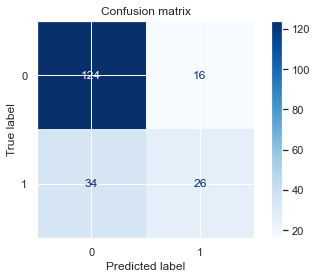

     Sensitivity  Specificity   Precision     Accuracy  
bais     0.89         0.43         0.62         0.75    
base     0.86         0.50         0.61         0.76    


In [16]:
woman_frac = 0.3

X_bias = gen_entries_woman(len(X_train), woman_frac)
y_bias = logreg.predict(X_bias)

#np.random.seed(seed)
model_secret = deepcopy(model_overfit.fit(X_bias, y_bias))
uti.mesure_clas_list([model_secret, logreg], X_test, y_test, ['bais', 'base'])

Nous venons de créer notre modèle secret qui a été entraîné avec une proportion de femmes de 30 %. On veut maintenant savoir si nous sommes capables de retrouver cette proportion en ayant accès à ce modèle en boîte noire uniquement.

Pour procéder à l'inférence de propriété on propose la méthode suivante basée sur [lien ?].
Dans un premier temps, on cherche à déterminer si la base de données d'entraînement de `model_secret` contient plus d'hommes ou plus de femmes.

On commence par générer 150 bases de données dont la fraction de femmes suit une loi normale centrée en 0.4 et d’écart type 0.05. Dans ces bases de données, il y a plus d’hommes que de femmes (en moyenne 60% d’hommes). On génère ensuite 150 bases de données dont la fraction de femmes    suit une loi normale centrée en 0.6 et d’écart type 0.05. Dans ces bases de données, il y a plus de femmes que de d’hommes (en moyenne 40% d’hommes).

-----------------------------
[RAPPORT]

De façon plus détaillée, pour créer une base de données dont la fraction de femmes suit une loi normale centrée en 0.4 :
    - on tire aléatoirement une fraction `frac` selon une loi normale centrée en 0.4 d'écart type 0.05.
    - on génère des entrées telles que la variable `sex` ait une proportion `frac` de femme dans cette base de données et que les autres variables suivent une loi uniforme.
    - on labellise les entrées en utilisant le modèle de départ `logreg`.
    
----------------------------------- 

Ensuite pour chaque base de donnée créée, on crée un modèle ( de régression logistique) que l’on entraîne sur la base de données correspondante (soit 300 modèles différents en tout).

On crée maintenant un méta modèle `meta_model` qui est une régression logistique qui prend en entrée les coefficients d’un modèle et le place dans la classe 0 ou la classe 1. La classe 0 correspond à un modèle s’étant entraîné sur une base de données ayant moins de filles et la classe 1 à un modèle s’étant entraîné sur une base de données ayant plus de filles. 

On entraîne ainsi notre méta modèle sur les 300 modèles précédemment créés.

On donne enfin le modèle `model_secret` à notre méta modèle et on observe la sortie de celui-ci.
Si ce dernier le place dans la classe 0 alors il suppose que le modèle secret s’est entraîné avec moins d’exemples de femmes et s’il le place dans la classe 1 alors il suppose que le modèle secret s’est entraîné avec plus d’exemples de femmes.

L’implémentation de ces étapes est faites dans les lignes de codes suivantes.


In [17]:
def gen_models(architecture, n_models, n_entries, unif=False):
    
    np.random.seed(seed)
    dist_woman = []
    
    for _ in range(n_models):
        mean = np.random.choice([0.4, 0.6])
        dist = np.clip(np.random.normal(mean, scale=0.05), 0, 1)
        dist_woman.append(dist)
    dist_woman = np.array(dist_woman)
    
    list_X = [gen_entries_woman(n_entries, dist) for dist in tqdm(dist_woman)]
    
    flatten_list = pd.DataFrame(np.array(list_X).reshape(-1, 21), 
                                columns=X.columns)
    list_y = logreg.predict(flatten_list).reshape(n_models, -1)
    
    list_models = [deepcopy(model_archi.fit(X, y))
                                       for X, y in tqdm(zip(list_X, list_y))]
  
    return list_models, dist_woman

In [18]:
# set the number of database and the number of entries in each
n_models = 300
n_entries = len(X_train)

# chose if the distribution of all variables except 'sex' is choosen with 
# the distribution of the secret database or uniformaly
unif = False

# model architechture : model, model_overfit
model_archi = model_overfit

# names for the file
name = '_overfit' if model_archi == model_overfit else ''
dist_name = '_unif' if unif else '_prop'


if NEW:
    list_models, dist_woman = gen_models(model_archi, n_models, n_entries, unif)
    meta_X = [model['logreg'].coef_[0] for model in list_models]
    
    np.savez_compressed(f'data/privacy/data_{name}{dist_name}.npz', 
                        meta_X=meta_X, 
                        dist_woman=dist_woman)
else:
    file = np.load(f'data/privacy/data_{name}{dist_name}.npz', allow_pickle=True)
    meta_X = file['meta_X']
    dist_woman = file['dist_woman']
    
meta_y = (dist_woman > 0.5).astype('int')

### Visualisation de la répartition de la proportion d'hommes dans les bases de données

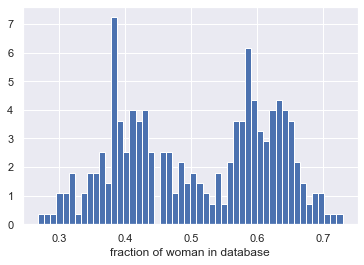

In [19]:
plt.hist(dist_woman, density=True, bins=50)
plt.xlabel('fraction of woman in database')
plt.show()

On peut visualiser sur ce graphique que la proportion de femmes dans les bases de données créées sont bien distribuées autour de 0.4 et de 0.6. On a ensuite créé un modèle par base de données et l’avons entraîné sur celle-ci.
On va maintenant entraîner notre méta modèle à l’aide des 300 modèles générés.

### Entraînement du méta-modèle

In [20]:
split = model_selection.train_test_split(meta_X, 
                                         meta_y,
                                         test_size=0.20)
X_train_meta, X_test_meta, y_train_meta, y_test_meta = split

meta_model = LogisticRegression(max_iter=200)

np.random.seed(seed)
meta_model.fit(X_train_meta, y_train_meta)

pred = meta_model.predict([model_secret['logreg'].coef_[0]])[0]

print("(0 : majority of man, 1 : majority of woman)")
print(f"The model predictied : {pred}")

(0 : majority of man, 1 : majority of woman)
The model predictied : 0


On rappelle que notre méta modèle qui prend en entrée les coefficient d'un modèle et prédit si ce modèle a été entraîné sur une base avec une majorité de femmes ou non.

Le modèle secret a correctement prédit le fait que la base de données sur laquelle on a entraîné notre modèle est constituée de plus d’hommes que de femmes. 

Pour mesurer la qualité de la méthode que l’on vient d’implémenter, on utilise notre base de test pour le méta modèle.

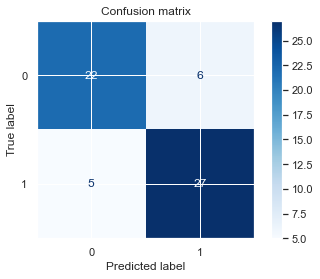

Sensitivity  Specificity   Precision     Accuracy  
    0.79         0.84         0.82         0.82    


In [21]:
uti.mesure_clas(meta_model, X_test_meta, y_test_meta)

Les métriques de performance montrent que le méta modèle prédit de façon juste si un modèle s'est entraîné sur une base de données constituée plus d'hommes que de femmes.
Nous allons passer à un niveau au-dessus et tenter de prédire la proportion de femmes présente dans la base d'entraînement utilisée pour entraîner un modèle.
Pour se faire, nous allons changer notre méta modèle et utiliser une régression linéaire plutôt qu'une régression logistique.
La variable cible n'est plus binaire mais continue et correspond à la fraction de femme dans la base d'entraînement utilisée pour entraîner le modèle d'entrée.

#### Régression linéaire pour trouver la proportion de femmes

Pour mesurer la performance de notre méta modèle linéaire on fait le calcul suivant pour les éléments de la base de test:
$$
| y_{true} - y_{pred} | * 100
$$
avec $y_{true}$ la fraction de femme de la base d'entraînement, $y_{pred}$ la prédiction du méta modèle. On moyenne ensuite sur l'ensemble des éléments de la base de test pour avoir le pourcentage d'erreurs moyen.


In [22]:
split = model_selection.train_test_split(meta_X, 
                                         dist_woman, 
                                         test_size=0.20, 
                                         random_state=seed)
X_train_meta, X_test_meta, y_train_meta, y_test_meta = split

meta_model_linear = LinearRegression()
np.random.seed(seed)
meta_model_linear.fit(X_train_meta, y_train_meta)

y_pred_meta = meta_model_linear.predict(X_test_meta)
err = (np.abs(y_test_meta - y_pred_meta) * 100).mean()

print(f'Mean pourcentage error: {err:.2f}')

Mean pourcentage error: 7.61


Les métriques montrent que l'on a un méta modèle capable de retrouver assez précisément la fraction de femmes utilisées pour entraîner un modèle avec une erreur moyenne de %.
Cette erreur est faible si l’on garde en tête le fait que l’on a seulement utilisé les coefficients du modèle pour retrouver cette information qui est propre à la base de données.

Regardons maintenant la prédiction du méta modèle sur le modèle secret.

In [23]:
predict = meta_model_linear.predict(model_secret['logreg'].coef_)
true = woman_frac

print(f'Real       : {true}')
print(f'Predictied : {predict[0]:.2f}')

Real       : 0.3
Predictied : 0.44


On a une prédiction qui est proche de la proportion de femme présente dans la base de données d'entraînement. On est ainsi satisfait de notre attaque.

---
[MOD]

Cette partie montre donc que lorsque la notion de protection des données n'est pas prise en compte la récupération de modèle ou l'inférence de propriété sont possible. Les hypothèse faites pour les différentes implémentations peuvent être assoupli en fonction de cas mais reste raisonnablement vérifiables. Les méthodes de défense contre la copie de modèles sont majoritairement des méthodes non technique comme la limitation d'utilisation ou une implémentation en API qui permet de contrôler plus précisément les demandes. Pour l'inférence il existe des méthodes que l'on peut implémenter lors de l'entraînement pour rendre plus difficile ces attaques.

---

---
[MOD]

## Mitiger les dégâts

La méthode la plus populaire pour mitiger les attaques d'inférence est la confidentialité différentielle (*differental privacy*). L'idée fondamentale de cette méthode est l'aléatoire. On introduit à un moment de la conception d'un modèle (soit dans les données, soit lors de l'entraînement) du bruit indépendant des données du modèle. Le but étant de conserver une sortie proche de la sortie d'un modèle sans bruit tout en s'assurant que on ne puisse pas soutirer de cette sortie des informations sur les données du modèle. 

L'implémentation de cette méthode dépends du modèle statistique choisi, par exemple la confidentialité différentielle pour une régression logistique et un réseau de neurone n'est pas la même. Mais de manière générale la confidentialité différentielle dépends principalement d'un paramètre : $\epsilon$ 

La confidentialité différentiable autorise une certaine quantité d'information à fuité et cette quantité est contrôlée par le paramètre $\epsilon$ appeler le *budget de confidentialité*. Plus la valeur de ce paramètre est petit plus le modèle sera considéré comme protégé. 

Il existe plusieurs librairies implémentant des outils de confidentialité différentielles qui sont listées dans la dernière partie. 
Dans notre cas on utilise la librairie *diffprivlib* (IBM) qui permet d'implémenter ces méthodes avec des modèles de *sklearn*.

L'implémentation se fait en remplaçant uniquement le modèle de régression logistique dans notre modèle d'origine. On le remplace par la régression logistique de la librairie *diffprivlib*. 

Pour l'implémentation de cette méthode il faut fixer deux paramètres :
 - $\epsilon$ : le budget de confidentialité
 - $\delta$ : une borne de régularisation
 
On ne s'occupera pas du deuxième paramètre.

---

In [24]:
epsilon = 10
data_norm = 10

model_overfit_diff = Pipeline(
    steps=[
        ('relations', FunctionTransformer(add_relations)), 
        ('preprocessor', preprocessor_comb),
        # The only difference with model_over
        ('logreg', diff.LogisticRegression(max_iter=200, data_norm=data_norm))
    ]
)

---
[MOD]

Pour vérifier l'implémentation de la confidentialité différentielle on vérifie que lorsque l'on augmente le paramètre $\epsilon$ on tends vers la performance du modèle sans cette méthode.

---

In [25]:
if NEW:
    results = pd.DataFrame()
    for epsilon in tqdm(np.logspace(-3, 4, 40)):
        for _ in range(100):
            model_overfit_diff.set_params(logreg__epsilon=epsilon)
            model_overfit_diff.fit(X_train, y_train)
            accuracy = model_overfit_diff.score(X_test, y_test)

            results = results.append({'accuracy': accuracy, 'epsilon':epsilon}, 
                                     ignore_index=True)
            
    np.savez_compressed(f'data/privacy/diffpriv.npz', results=results)
else:
    file = np.load(f'data/privacy/diffpriv.npz', allow_pickle=True)
    results = pd.DataFrame(file['results'], columns=['accuracy', 'epsilon'])

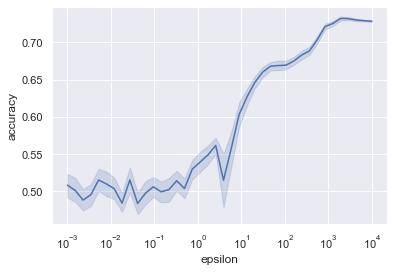

In [26]:
grid = sns.lineplot(x='epsilon', y='accuracy', data=results)
grid.set(xscale="log")
plt.show()

---
[MOD]

On observe donc bien la relation entre le paramètre *epsilon* et l'*accuracy*. Plus on relâche la contrainte plus le modèle est performant. On note également que lorsque le budget est trop faible, le modèle devient inutilisable. En effet, un modèle de classification binaire qui prédirait aléatoirement à une *accuracy* de 0.5

Pour tester l'efficacité de cette méthode nous allons générer de la même manière que lors de l'attaque d'inférence de propriété une base de données contenant des coefficients de modèles entraînés sans confidentialité différentiel sur des bases de données avec plus ou mon de femme. 

On créer un méta modèle qui distingue les modèles entraînés sur une base de données avec une majorité de femme ou non. 

On va ensuite générer des modèles en augmentant progressivement le budget $\epsilon$ et mesurer le nombre de modèles que notre méta modèle est capable de prédire correctement. 

On s'attend à voir que plus le budget est faible plus le méta modèle à du mal à distinguer les deux cas. 

---

In [27]:
n_models = 300
n_entries = len(X_train)

# chose if the distribution of all variables except 'sex' is choosen with 
# the distribution of the secret database or uniformaly
unif = False

dist_name = '_unif' if unif else '_prop'

# setting epsilon as 'inf' is the same as having no differential privacy
model_overfit_diff.set_params(logreg__epsilon=float('inf'))
model_archi = model_overfit_diff

if NEW:
    list_models, dist_woman = gen_models(model_archi, n_models, n_entries, unif)
    
    meta_X_train = [model['logreg'].coef_[0] for model in list_models]
    meta_y_train = (dist_woman > 0.5).astype('int')
    
    np.savez_compressed(f'data/privacy/data_diff{dist_name}.npz', 
                        meta_X_train=meta_X_train, 
                        meta_y_train=meta_y_train)
else:
    file = np.load(f'data/privacy/data_diff{dist_name}.npz', allow_pickle=True)
    meta_X_train = file['meta_X_train']
    meta_y_train = file['meta_y_train']

In [28]:
meta_model = LogisticRegression(max_iter=200)
meta_model.fit(meta_X_train, meta_y_train)

LogisticRegression(max_iter=200)

In [38]:
n_models = 100
n_entries = len(X_train)

columns=['epsilon', 'accuracy', 'sensitivity', 
         'specificity', 'precision']

model_archi = model_overfit_diff

if NEW:
    list_score, list_meta_score = [], []
    for epsilon in np.logspace(-1, 5, 10):
        model_archi.set_params(logreg__epsilon=epsilon)
        list_models, dist_woman = gen_models(model_archi, n_models, n_entries)
        
        meta_X_test = [model['logreg'].coef_[0] for model in list_models] 
        meta_y_test = (dist_woman > 0.5).astype('int')
        
        list_meta_score.append(meta_model.score(meta_X_test, meta_y_test))
        
        list_score.append([model.score(y_test, model.predict(X_test)) 
                                           for model in list_models])
       
    np.savez_compressed(f'data/privacy/data_diff{dist_name}_test.npz', 
                        list_meta_score=list_meta_score,
                        list_socre=list_score)
else:
    file = np.load(f'data/privacy/data_diff{dist_name}_test.npz', allow_pickle=True)
    list_score = file['list_socre']
    list_meta_score = file['list_meta_score']

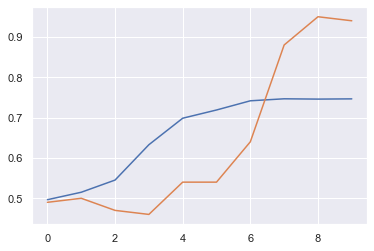

In [39]:
plt.plot(range(10), np.array(list_score).mean(axis=1))
plt.plot(range(10), np.array(list_meta_score))
plt.show()

---
[MOD]

Ce graphique montre bien l'effet de la confidentialité différentiable sur l'attaque d'inférence de propriété et le compromis qui existe entre la confidentialité et les performance de la méthode. 
Plus le budget $\epsilon$ augmente plus l'attaque est efficace, lorsqu'il est vers 0.1 l'attaque ne parvient pas à distinguer entre les modèles entraîné sur des bases avec plus de femmes et les autres. Cela est vrai jusqu'à un $\epsilon$ proche de 100 où le méta modèle parvient à faire mieux qu'une classification aléatoire. Vers $\epsilon$ proche de 10000, le modèle est capable presque à chaque fois de prédire juste.
On remarque également que les modèles sous-jacents, ceux que le méta modèle essai de classifier, sont de plus en plus performant à mesure que le budget augmente. 

Le modèle idéal est donc un modèle résistant au mieux à cette attaque tout en étant le plus performant possible. Il faut donc choisir un $\epsilon$ qui sépare le plus possible les deux courbes, ici proche de 100.

---

# Partie 3

Nous avons pu voir dans la partie précédente que le fait de négliger l’aspect protection des données lors de l’entraînement d’un modèle laissait la possibilité à une personne mal intentionnée de récupérer les paramètres de ce modèle ou d’avoir accès à des informations sur la base de données utilisée pour l'entraînement de ce dernier. Des solutions telles que le *differential privacy* impliquent un apprentissage dit “agrégé” qui permet de protéger les données d’entraînement. L’utilisation de ces solutions reste délicate et les raisons à cela sont données dans les paragraphes suivants.

## Le manque de ressource rend la prise en main des librairies difficile.

On constate qu’il y a trois librairies principales pour protéger la *privacy* :

 - Diffprivlib : développée par IBM depuis 2019
 - OpenDP : développée par OpenDP (Harvard) depuis 2019
 - Opacus : développée par Facebook depuis 2020
 - TensorFlow Privacy : dévoloppée par Google depuis 2019
 
Elles ont en commun d’être très récentes, elles sont donc plus difficiles à mettre en œuvre à cause du manque d’exemples et de retour utilisateur. Par exemple, la librairie *Diffprivlib* a une documentation claire et précise mais qui ne contient pas d’exemple d’implémentation. Ces exemples sont présents dans un autre dossier dans le  code du projet et restent assez peu nombreux. À cela s’ajoute le manque d’échange sur les plateforme d'entraide comme *stack overflow*. Pour *Diffprivlib* et *Opacus* on ne trouve que deux questions sans réponses et pour *OpenDP*, aucune question n’est présente. Ces échanges sont très importants pour le développement de ces libraires car ils proposent des exemples de cas réels et facilitent la compréhension des implémentations. La démocratisation de ces outils est donc très importante pour une adoption des outils. Pour espérer que cela soit le cas, il faut évidemment continuer de développer ces librairies, mais surtout d’encourager le maximum de personnes avec des connaissances techniques à utiliser les outils et de proposer un retour. La création d’exemples pertinents présents dans la documentation viendra de cet échange entre développeur et utilisateur. De plus, ces échanges permettent bien souvent d’avoir des avis sur les avantages et les inconvénients des différentes méthodes existantes. Les trois librairies ne contiennent d’ailleurs aucun document de comparaison. Tous ces problèmes impliquent qu’aujourd’hui si un individu s’intéresse à la protection des données dans des modèles statistiques il doit s’instruire de manière importante sur le sujet et avoir une idée très claire de ce qu’il cherche avant d’implémenter les méthodes. Encourager des méta analyses pourrait dans ce sens abaisser la barrière d’entrée en permettant de créer des intuitions sur les avantages et les inconvénient des méthodes de la protection des données. Ce manque de ressource est évidemment un frein pour les individus mais pour les industriels ces librairies sont d’autant plus difficile à mettre en place qu’ils ne sont pas les cibles de celles-ci.

## Le public visé par ces librairies ne permet pas une mise en œuvre efficace en entreprise.

Les trois librairies citées plus haut ont des méthodes et de la documentation d’une grande précision, mais elles ont l’inconvénient d’avoir été écrites pour des développeurs et des scientifiques et non pas des industriels. Comme dit plus haut, les concepteurs de ces librairies partent du principe que l’utilisateur à une bonne connaissance des dernières recherches en apprentissage statistique. Or, avant d’être un problème académique, la protection de la vie privée est un problème opérationnel. Les méthodes utiles pour des problèmes concrets sont perdues parmi les dizaines d’implémentations des dernières publications dans le domaine. Par exemple, *Opacus* ne s’implémente que sur des modèles codés en *PyTorch*, la librairie d’apprentissage profond de Facebook, et ne propose que trois exemples sur des réseaux complexes et récents (image classifier, text classifier, LSTM). Ces exemples sont intéressants d’un point de vue technique mais ne prennent pas en compte l’écart qu’il existe entre la réalité industrielle et le monde académique. Dans la majorité des cas les modèles utilisés sont soit relativement simples comme des régressions ou des arbres de décisions soit les modèles proviennent d’outils qui proposent des modèles complexes prêt à l'emploi. Pour une adoption rapide des méthodes de protection des données, il faut se concentrer sur la clarté et la simplicité des modèles utilisés en industries ou inclure ces méthodes dans les modèles pré-entraînés. 
Ces changements sont possibles si les industriels s'approprient le sujet. Tout comme l’exemple de *Hugging face* qui a démocratisé les modèles complexes de traitement du langage en s'adressant aux entreprises, on peut très bien imaginer qu’une entreprise s’empare du sujet. Il faut également poursuivre la production de communication non scientifique pour susciter une prise de conscience.

## Il existe un arbitrage fort entre performance et privacy

La dernière remarque sur cette partie est que l’utilisation de la privacy a un impact négatif sur le temps d'entraînement du modèle ou bien sur les performances de celui-ci. Protéger notre modèle implique donc de faire des concessions et comme nous allons le voir, il est possible de choisir les concessions que l’on souhaite faire. 
L’ajout de calcul à tout moment de l’implémentation d’un modèle entraîne un temps d'entraînement ou d'exécution plus long. Il faut donc choisir entre la mise en place d’un grand nombre de sécurité ou une utilisation rapide du modèle, cela dépendra de l'importance que l’on porte à la protection des données du modèle. Mais le temps n’est pas la seule contrainte, des méthodes de protection des données ont une influence sur les performances du modèle. Par exemple, le *differential privacy* permet de contrôler l’impacte de la méthode sur l’*accuracy* (la précision) d’un modèle. Un des paramètres de cette méthode est justement la variation maximale de l’*accuracy* que l’on est prêt à tolérer lors de l’ajout ou du retrait d’un élément de la base d’entraînement. Ce contrôle ne s’applique que pour la métrique d’*accuracy* mais il existe un grand nombre d’autres métriques permettant de rendre compte de la performance d’un modèle. Pour celles-ci, l'expérimentation est encore la meilleure solution. Il est intéressant de noter que des concessions sont également nécessaires entre les trois notions présentées dans ce rapport. Par exemple [arxiv.org/pdf/1905.12101.pdf] Bagdasaryan & Shmatikov (2019) démontre que l’impact de l’*accuracy* entraînait des conséquences non symétriques sur tous les groupes d’entrées. Ainsi les groupes sous représentés étaient plus touchés par la perte d’*accuracy*. De même, l'obfuscation de l'architecture ou des résultats qui permettra une meilleure contrôle sur la sécurité des données mais empêche d'implémenter des outils d’explications de décision. C’est ainsi que la protection des données d’un modèle peut se faire au détriment de la transparence. 
On a donc besoin de documents non techniques et de communication lorsque l’on explique les enjeux de la notion de protection des données. Comprendre les différentes options possibles et surtout rendre claire que la mise en place des outils implique des compromis. Des comparaisons des différentes méthodes et de leur impact sur les métriques devraient être présentes dans les exemples de librairies. 
